# CvT

In [1]:
import pandas as pd
import torch

In [2]:
# Load the data
df = pd.read_csv('./faces/fold_0_data.txt', sep="\t")

In [3]:
print(df.shape)
print(df.columns)
df.head()

(4484, 12)
Index(['user_id', 'original_image', 'face_id', 'age', 'gender', 'x', 'y', 'dx',
       'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score'],
      dtype='object')


user_id                original_image  face_id       age gender     x  \
0  30601258@N03  10399646885_67c7d20df9_o.jpg        1  (25, 32)      f     0   
1  30601258@N03  10424815813_e94629b1ec_o.jpg        2  (25, 32)      m   301   
2  30601258@N03  10437979845_5985be4b26_o.jpg        1  (25, 32)      f  2395   
3  30601258@N03  10437979845_5985be4b26_o.jpg        3  (25, 32)      m   752   
4  30601258@N03  11816644924_075c3d8d59_o.jpg        2  (25, 32)      m   175   

      y    dx    dy  tilt_ang  fiducial_yaw_angle  fiducial_score  
0   414  1086  1383      -115                  30              17  
1   105   640   641         0                   0              94  
2   876   771   771       175                 -30              74  
3  1255   484   485       180                   0              47  
4    80   769   768       -75                   0              34

In [4]:
# Load the other dataframes
df1 = pd.read_csv('./faces/fold_1_data.txt', sep="\t")
df2 = pd.read_csv('./faces/fold_2_data.txt', sep="\t")
df3 = pd.read_csv('./faces/fold_3_data.txt', sep="\t")
df4 = pd.read_csv('./faces/fold_4_data.txt', sep="\t")

# Concatenate all the dataframes
df = pd.concat([df, df1, df2, df3, df4]).reset_index(drop=True)

In [5]:
print(df.shape)
print(df.columns)
df.head()

(19370, 12)
Index(['user_id', 'original_image', 'face_id', 'age', 'gender', 'x', 'y', 'dx',
       'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score'],
      dtype='object')


user_id                original_image  face_id       age gender     x  \
0  30601258@N03  10399646885_67c7d20df9_o.jpg        1  (25, 32)      f     0   
1  30601258@N03  10424815813_e94629b1ec_o.jpg        2  (25, 32)      m   301   
2  30601258@N03  10437979845_5985be4b26_o.jpg        1  (25, 32)      f  2395   
3  30601258@N03  10437979845_5985be4b26_o.jpg        3  (25, 32)      m   752   
4  30601258@N03  11816644924_075c3d8d59_o.jpg        2  (25, 32)      m   175   

      y    dx    dy  tilt_ang  fiducial_yaw_angle  fiducial_score  
0   414  1086  1383      -115                  30              17  
1   105   640   641         0                   0              94  
2   876   771   771       175                 -30              74  
3  1255   484   485       180                   0              47  
4    80   769   768       -75                   0              34

In [6]:
df['gender'].value_counts()

gender
f    9372
m    8120
u    1099
Name: count, dtype: int64

In [7]:
# sample 10000 images, with an equal number of each gender
df_male = df[df['gender'] == 'm'].sample(n=5000, random_state=23)
df_female = df[df['gender'] == 'f'].sample(n=5000, random_state=23)
df = pd.concat([df_male, df_female]).reset_index(drop=True)
print(df['gender'].value_counts())

gender
m    5000
f    5000
Name: count, dtype: int64


In [8]:
# drop the rows with u or nan for gender
df = df[(df['gender'] != 'u') & (df['gender'].notnull())]
df['gender'].value_counts()

gender
m    5000
f    5000
Name: count, dtype: int64

In [9]:
# encode gender column as male
df['male'] = df['gender'].apply(lambda x: 1 if x == 'm' else 0)
df['male'].value_counts()

male
1    5000
0    5000
Name: count, dtype: int64

In [10]:
# Create a new column with the path to the images
df['path'] = df['user_id'] + '/' + "coarse_tilt_aligned_face." + df['face_id'].astype(str) + "." + df['original_image']
df['path'].head()

0    62282816@N03/coarse_tilt_aligned_face.1470.117...
1    10792106@N03/coarse_tilt_aligned_face.533.1108...
2    37303189@N08/coarse_tilt_aligned_face.84.88635...
3    50739822@N00/coarse_tilt_aligned_face.1367.988...
4    112114373@N07/coarse_tilt_aligned_face.1198.11...
Name: path, dtype: object

In [11]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image


dim = 224


class ImageDataset(Dataset):
  def __init__(self, annotations_df, img_dir, dim=dim, transform=None, target_transform=None):
    self.annotations_df = annotations_df
    self.img_dir = img_dir
    self.dim = dim
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.annotations_df)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.annotations_df.loc[idx, 'path'])
    # read the image and resize
    image = Image.open(img_path).convert("RGB")
    image = image.resize((self.dim, self.dim))
    image = ToTensor()(image)
    label = self.annotations_df.loc[idx, 'male']
    label = torch.tensor(label)
    if self.transform:
        image = self.transform(image, self.dim)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

In [12]:
from torchvision import transforms

def transform_image(image, dim):
  # data augmentation
  transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(dim, scale=(0.8, 1.0), ratio=(1.0,1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
  ])
  return transform(image)

In [13]:
# Get train, validation and test sets (80-10-10)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=23)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=23)

# Create the datasets
train_dataset = ImageDataset(train_df.reset_index(drop=True), './faces/', dim=dim, transform=transform_image)
val_dataset = ImageDataset(val_df.reset_index(drop=True), './faces/', dim=dim)
test_dataset = ImageDataset(test_df.reset_index(drop=True), './faces/', dim=dim)

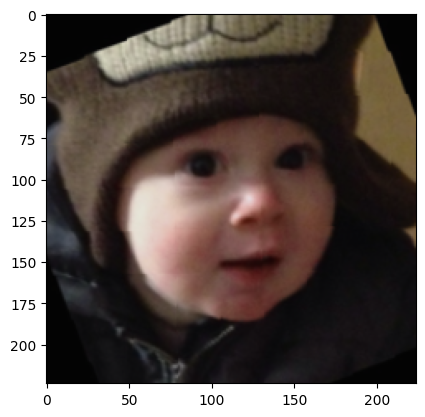

In [14]:
# show an image
image, label = train_dataset[1]
plt.imshow(image.permute(1, 2, 0))
plt.show()

In [15]:
# Define the dataloaders
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
labels = ["female", "male"]
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

## 8000 Training datapoints

### Train from scratch

In [22]:
from transformers import CvtConfig, CvtForImageClassification

# Initializing a configuration for CvT microsoft/cvt-13 architecture
config = CvtConfig(num_labels=2)

# Initializing a model (with random weights) from the cvt-13 configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cvt_13 = CvtForImageClassification(config).to(device)

config

CvtConfig {
  "_attn_implementation_autoset": true,
  "attention_drop_rate": [
    0.0,
    0.0,
    0.0
  ],
  "cls_token": [
    false,
    false,
    true
  ],
  "depth": [
    1,
    2,
    10
  ],
  "drop_path_rate": [
    0.0,
    0.0,
    0.1
  ],
  "drop_rate": [
    0.0,
    0.0,
    0.0
  ],
  "embed_dim": [
    64,
    192,
    384
  ],
  "initializer_range": 0.02,
  "kernel_qkv": [
    3,
    3,
    3
  ],
  "layer_norm_eps": 1e-12,
  "mlp_ratio": [
    4.0,
    4.0,
    4.0
  ],
  "model_type": "cvt",
  "num_channels": 3,
  "num_heads": [
    1,
    3,
    6
  ],
  "padding_kv": [
    1,
    1,
    1
  ],
  "padding_q": [
    1,
    1,
    1
  ],
  "patch_padding": [
    2,
    1,
    1
  ],
  "patch_sizes": [
    7,
    3,
    3
  ],
  "patch_stride": [
    4,
    2,
    2
  ],
  "qkv_bias": [
    true,
    true,
    true
  ],
  "qkv_projection_method": [
    "dw_bn",
    "dw_bn",
    "dw_bn"
  ],
  "stride_kv": [
    2,
    2,
    2
  ],
  "stride_q": [
    1,
    1,
   

In [23]:
cvt_13

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [24]:
# Check the number of parameters
total_params = sum([param.numel() for param in cvt_13.parameters()])
print(f'{total_params:,} total parameters.')

19,613,250 total parameters.


In [25]:
from transformers import AutoImageProcessor

# Load the image processor
image_processor = AutoImageProcessor.from_pretrained("microsoft/cvt-13")

In [20]:
image_processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [ ]:
# Define the loss function and the optimizer
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(cvt_13.parameters(), lr=0.0001)

# Define early stopping
class EarlyStopper:
  def __init__(self, patience=5, min_delta=0.001):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_loss = float('inf')

  def early_stop(self, loss):
    if loss < self.min_loss:
      self.min_loss = loss
      self.counter = 0
    elif loss > (self.min_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

early_stopper = EarlyStopper(patience=5, min_delta=0.001)

In [24]:
# Train the model
n_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
min_val_loss = float('inf')

for epoch in range(n_epochs):
  print(f'===== Epoch {epoch+1} =====')
  train_loss = 0.0
  val_loss = 0.0
  train_accuracy = 0
  val_accuracy = 0

  # Training
  cvt_13.train()
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
    outputs = cvt_13(**inputs).logits
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_accuracy += (outputs.argmax(1) == labels).sum().item()
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_accuracy /= len(train_loader.dataset)
  train_accuracies.append(train_accuracy)

  print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

  # Validation
  cvt_13.eval()
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
      outputs = cvt_13(**inputs).logits
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      val_accuracy += (outputs.argmax(1) == labels).sum().item()
  val_loss /= len(val_loader)
  val_losses.append(val_loss)
  val_accuracy /= len(val_loader.dataset)
  val_accuracies.append(val_accuracy)

  # Save the best model
  if val_loss < min_val_loss:
    torch.save(cvt_13.state_dict(), 'cvt_13.pth')
    min_val_loss = val_loss

  # Early stopping
  if early_stopper.early_stop(val_loss):
    print('Early stopping')
    break

  print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

===== Epoch 1 =====
Training Loss: 0.7134, Training Accuracy: 0.5356
Validation Loss: 0.6624, Validation Accuracy: 0.5980
===== Epoch 2 =====
Training Loss: 0.6653, Training Accuracy: 0.5924
Validation Loss: 0.6305, Validation Accuracy: 0.6560
===== Epoch 3 =====
Training Loss: 0.6417, Training Accuracy: 0.6149
Validation Loss: 0.6054, Validation Accuracy: 0.6570
===== Epoch 4 =====
Training Loss: 0.6128, Training Accuracy: 0.6491
Validation Loss: 0.5607, Validation Accuracy: 0.6970
===== Epoch 5 =====
Training Loss: 0.6024, Training Accuracy: 0.6601
Validation Loss: 0.5587, Validation Accuracy: 0.7110
===== Epoch 6 =====
Training Loss: 0.5878, Training Accuracy: 0.6666
Validation Loss: 0.5239, Validation Accuracy: 0.7260
===== Epoch 7 =====
Training Loss: 0.5665, Training Accuracy: 0.6835
Validation Loss: 0.5075, Validation Accuracy: 0.7440
===== Epoch 8 =====
Training Loss: 0.5662, Training Accuracy: 0.6793
Validation Loss: 0.4969, Validation Accuracy: 0.7460
===== Epoch 9 =====
Trai

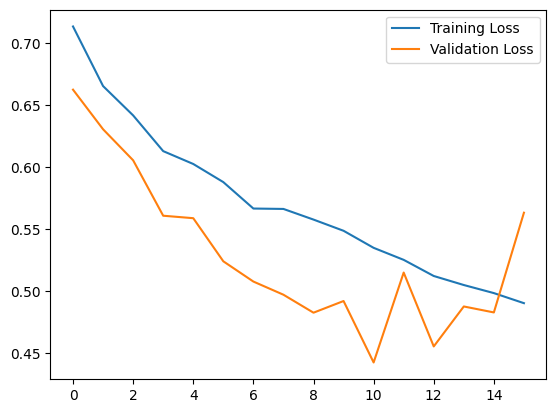

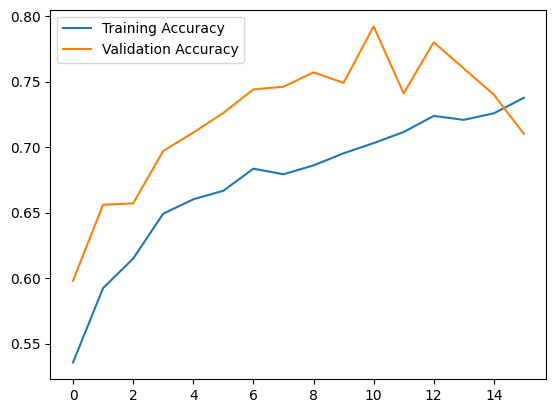

In [25]:
# Plot the losses and accuracies
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()

In [26]:
# Evaluate the model
cvt_13.load_state_dict(torch.load('cvt_13.pth'))
cvt_13.to(device)

cvt_13.eval()
test_accuracy = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
    outputs = cvt_13(**inputs).logits
    test_accuracy += (outputs.argmax(1) == labels).sum().item()
test_accuracy /= len(test_loader.dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')

C:\Users\waiho\AppData\Local\Temp\ipykernel_9912\207323365.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cvt_13.load_state_dict(torch.load('cvt_13.pth'))


Test Accuracy: 0.7990


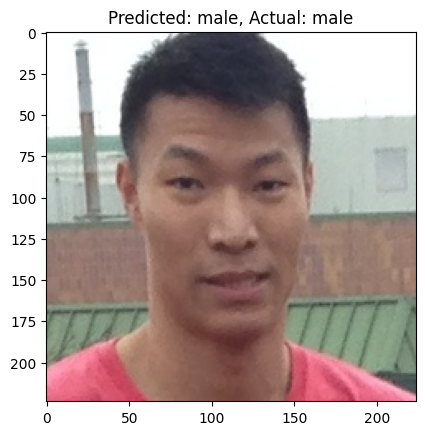

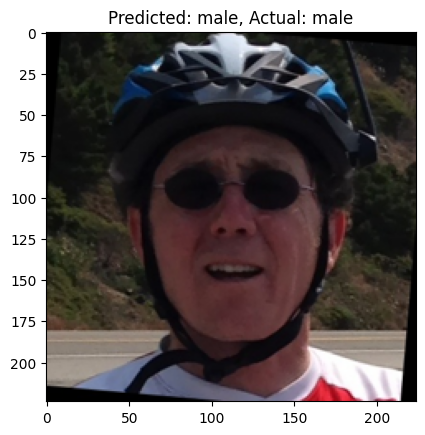

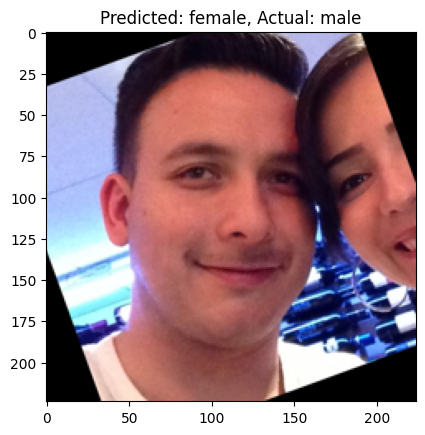

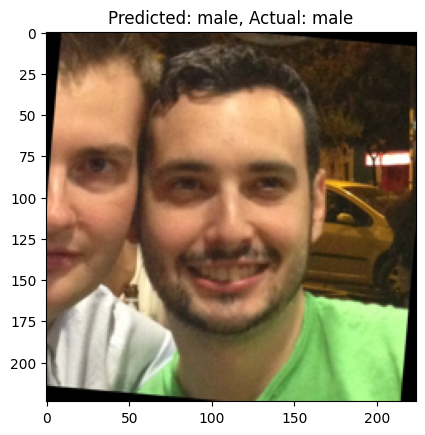

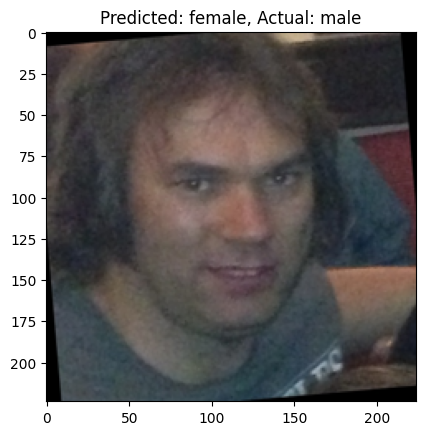

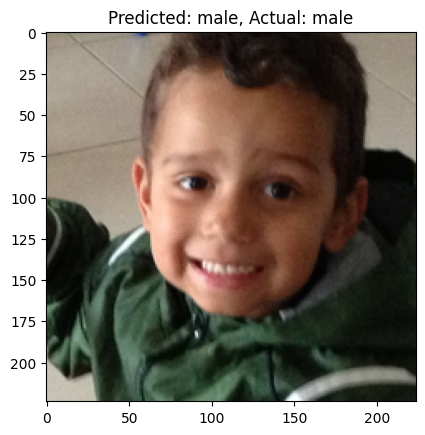

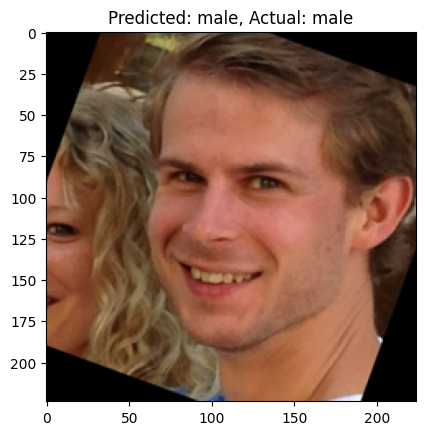

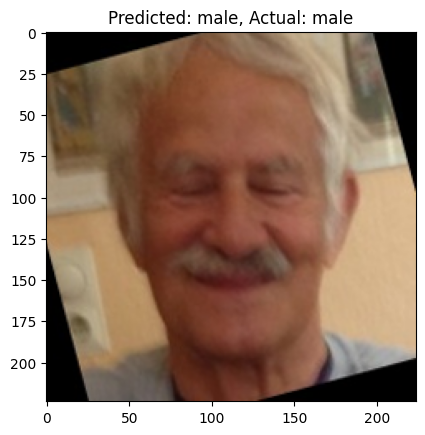

In [31]:
# Show some predictions
cvt_13.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
outputs = cvt_13(**inputs).logits
predicted = outputs.argmax(1)
for i in range(8):
  plt.imshow(images[i].cpu().permute(1, 2, 0))
  predicted_gender = id2label[predicted[i].item()]
  actual_gender = id2label[labels[i].item()]
  plt.title(f'Predicted: {predicted_gender}, Actual: {actual_gender}')
  plt.show()

### Transfer Learning

In [17]:
from transformers import AutoImageProcessor, CvtForImageClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cvt_13 = CvtForImageClassification.from_pretrained("microsoft/cvt-13").to(device)


In [18]:
cvt_13

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [19]:
# Check the number of parameters
total_params = sum([param.numel() for param in cvt_13.parameters()])
print(f'{total_params:,} total parameters.')

19,997,480 total parameters.


In [20]:
from transformers import AutoImageProcessor

# Load the image processor
image_processor = AutoImageProcessor.from_pretrained("microsoft/cvt-13")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [21]:
image_processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [ ]:
# Define the loss function and the optimizer
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(cvt_13.parameters(), lr=0.0001)

# Define early stopping
class EarlyStopper:
  def __init__(self, patience=5, min_delta=0.001):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_loss = float('inf')

  def early_stop(self, loss):
    if loss < self.min_loss:
      self.min_loss = loss
      self.counter = 0
    elif loss > (self.min_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

early_stopper = EarlyStopper(patience=5, min_delta=0.001)

In [23]:
# Train the model
n_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
min_val_loss = float('inf')

for epoch in range(n_epochs):
  print(f'===== Epoch {epoch+1} =====')
  train_loss = 0.0
  val_loss = 0.0
  train_accuracy = 0
  val_accuracy = 0

  # Training
  cvt_13.train()
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
    outputs = cvt_13(**inputs).logits
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_accuracy += (outputs.argmax(1) == labels).sum().item()
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_accuracy /= len(train_loader.dataset)
  train_accuracies.append(train_accuracy)

  print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

  # Validation
  cvt_13.eval()
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
      outputs = cvt_13(**inputs).logits
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      val_accuracy += (outputs.argmax(1) == labels).sum().item()
  val_loss /= len(val_loader)
  val_losses.append(val_loss)
  val_accuracy /= len(val_loader.dataset)
  val_accuracies.append(val_accuracy)

  # Save the best model
  if val_loss < min_val_loss:
    torch.save(cvt_13.state_dict(), 'cvt_13_finetune.pth')
    min_val_loss = val_loss

  # Early stopping
  if early_stopper.early_stop(val_loss):
    print('Early stopping')
    break

  print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

===== Epoch 1 =====
Training Loss: 1.0474, Training Accuracy: 0.6809
Validation Loss: 0.2379, Validation Accuracy: 0.8990
===== Epoch 2 =====
Training Loss: 0.4932, Training Accuracy: 0.8041
Validation Loss: 0.1971, Validation Accuracy: 0.9250
===== Epoch 3 =====
Training Loss: 0.4343, Training Accuracy: 0.8254
Validation Loss: 0.1460, Validation Accuracy: 0.9450
===== Epoch 4 =====
Training Loss: 0.3959, Training Accuracy: 0.8436
Validation Loss: 0.1886, Validation Accuracy: 0.9250
===== Epoch 5 =====
Training Loss: 0.3675, Training Accuracy: 0.8591
Validation Loss: 0.1149, Validation Accuracy: 0.9630
===== Epoch 6 =====
Training Loss: 0.3388, Training Accuracy: 0.8661
Validation Loss: 0.1295, Validation Accuracy: 0.9600
===== Epoch 7 =====
Training Loss: 0.3082, Training Accuracy: 0.8695
Validation Loss: 0.1339, Validation Accuracy: 0.9570
===== Epoch 8 =====
Training Loss: 0.2965, Training Accuracy: 0.8702
Validation Loss: 0.1386, Validation Accuracy: 0.9560
===== Epoch 9 =====
Trai

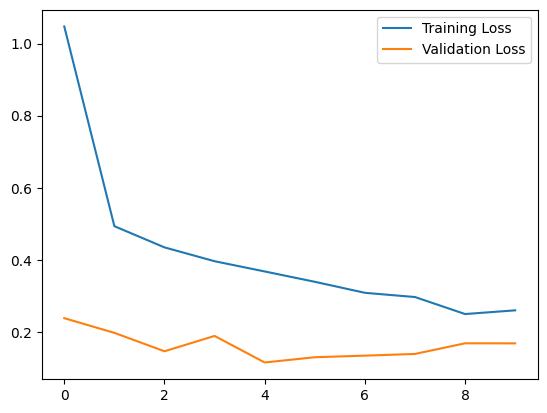

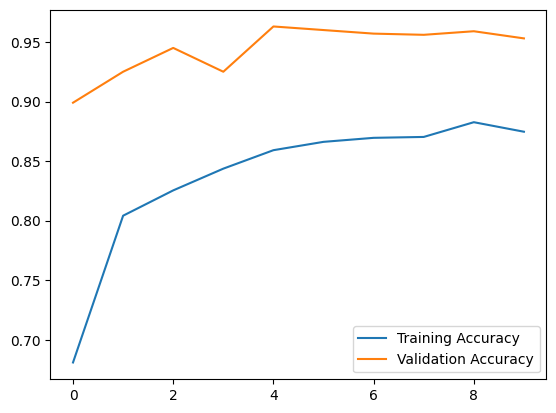

In [24]:
# Plot the losses and accuracies
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()

In [25]:
# Evaluate the model
cvt_13.load_state_dict(torch.load('cvt_13_finetune.pth'))
cvt_13.to(device)

cvt_13.eval()
test_accuracy = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
    outputs = cvt_13(**inputs).logits
    test_accuracy += (outputs.argmax(1) == labels).sum().item()
test_accuracy /= len(test_loader.dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')

C:\Users\waiho\AppData\Local\Temp\ipykernel_21960\229440522.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cvt_13.load_state_dict(torch.load('cvt_13_finetune.pth'))


Test Accuracy: 0.9520


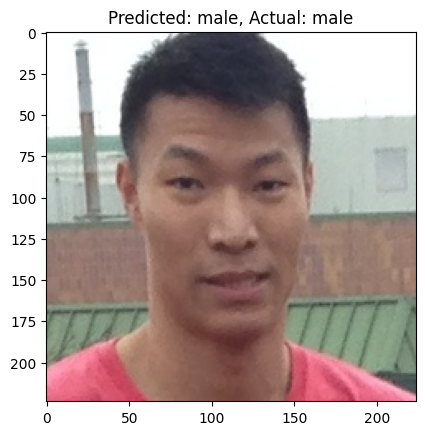

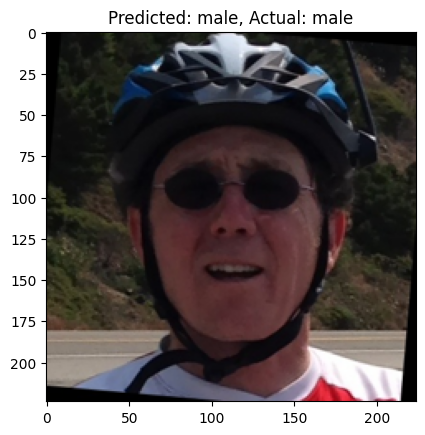

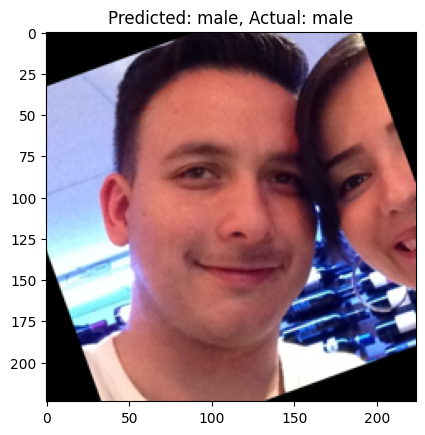

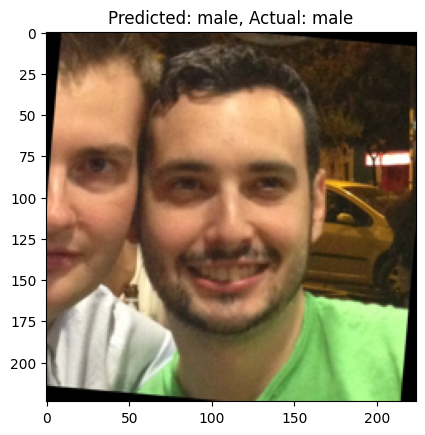

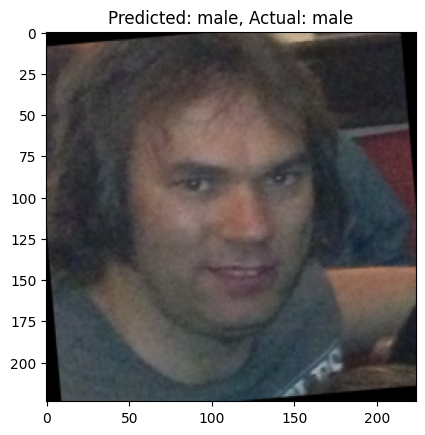

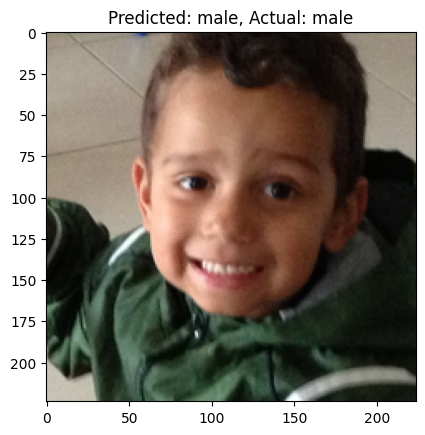

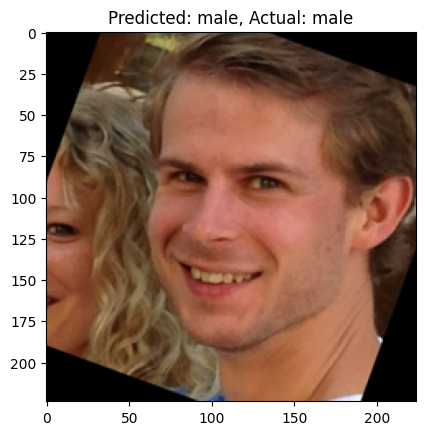

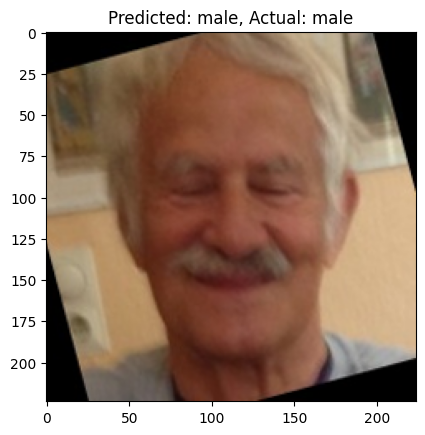

In [26]:
# Show some predictions
cvt_13.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
outputs = cvt_13(**inputs).logits
predicted = outputs.argmax(1)
for i in range(8):
  plt.imshow(images[i].cpu().permute(1, 2, 0))
  predicted_gender = id2label[predicted[i].item()]
  actual_gender = id2label[labels[i].item()]
  plt.title(f'Predicted: {predicted_gender}, Actual: {actual_gender}')
  plt.show()

## Less Training Data (3200 Training datapoints)

In [17]:
# sample 4000 images, with an equal number of each gender
df_male = df[df['gender'] == 'm'].sample(n=2000, random_state=23)
df_female = df[df['gender'] == 'f'].sample(n=2000, random_state=23)
df = pd.concat([df_male, df_female]).reset_index(drop=True)
print(df['gender'].value_counts())

gender
m    2000
f    2000
Name: count, dtype: int64


In [18]:
# drop the rows with u or nan for gender
df = df[(df['gender'] != 'u') & (df['gender'].notnull())]
df['gender'].value_counts()

gender
m    2000
f    2000
Name: count, dtype: int64

In [19]:
# encode gender column as male
df['male'] = df['gender'].apply(lambda x: 1 if x == 'm' else 0)
df['male'].value_counts()

male
1    2000
0    2000
Name: count, dtype: int64

In [20]:
# Create a new column with the path to the images
df['path'] = df['user_id'] + '/' + "coarse_tilt_aligned_face." + df['face_id'].astype(str) + "." + df['original_image']
df['path'].head()

0    10440927@N07/coarse_tilt_aligned_face.768.1209...
1    9017386@N06/coarse_tilt_aligned_face.223.10770...
2    86629393@N00/coarse_tilt_aligned_face.1797.116...
3    30601258@N03/coarse_tilt_aligned_face.2.104537...
4    8410632@N03/coarse_tilt_aligned_face.1780.1125...
Name: path, dtype: object

In [21]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image


dim = 224


class ImageDataset(Dataset):
  def __init__(self, annotations_df, img_dir, dim=dim, transform=None, target_transform=None):
    self.annotations_df = annotations_df
    self.img_dir = img_dir
    self.dim = dim
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.annotations_df)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.annotations_df.loc[idx, 'path'])
    # read the image and resize
    image = Image.open(img_path).convert("RGB")
    image = image.resize((self.dim, self.dim))
    image = ToTensor()(image)
    label = self.annotations_df.loc[idx, 'male']
    label = torch.tensor(label)
    if self.transform:
        image = self.transform(image, self.dim)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

In [22]:
from torchvision import transforms

def transform_image(image, dim):
  # data augmentation
  transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(dim, scale=(0.8, 1.0), ratio=(1.0,1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
  ])
  return transform(image)

In [23]:
# Get train, validation and test sets (80-10-10)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=23)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=23)

# Create the datasets
train_dataset = ImageDataset(train_df.reset_index(drop=True), './faces/', dim=dim, transform=transform_image)
val_dataset = ImageDataset(val_df.reset_index(drop=True), './faces/', dim=dim)
test_dataset = ImageDataset(test_df.reset_index(drop=True), './faces/', dim=dim)

In [24]:
# Define the dataloaders
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
labels = ["female", "male"]
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

### Train from scratch

In [27]:
from transformers import CvtConfig, CvtForImageClassification

# Initializing a configuration for CvT microsoft/cvt-13 architecture
config = CvtConfig(num_labels=2)

# Initializing a model (with random weights) from the cvt-13 configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cvt_13 = CvtForImageClassification(config).to(device)

config

CvtConfig {
  "_attn_implementation_autoset": true,
  "attention_drop_rate": [
    0.0,
    0.0,
    0.0
  ],
  "cls_token": [
    false,
    false,
    true
  ],
  "depth": [
    1,
    2,
    10
  ],
  "drop_path_rate": [
    0.0,
    0.0,
    0.1
  ],
  "drop_rate": [
    0.0,
    0.0,
    0.0
  ],
  "embed_dim": [
    64,
    192,
    384
  ],
  "initializer_range": 0.02,
  "kernel_qkv": [
    3,
    3,
    3
  ],
  "layer_norm_eps": 1e-12,
  "mlp_ratio": [
    4.0,
    4.0,
    4.0
  ],
  "model_type": "cvt",
  "num_channels": 3,
  "num_heads": [
    1,
    3,
    6
  ],
  "padding_kv": [
    1,
    1,
    1
  ],
  "padding_q": [
    1,
    1,
    1
  ],
  "patch_padding": [
    2,
    1,
    1
  ],
  "patch_sizes": [
    7,
    3,
    3
  ],
  "patch_stride": [
    4,
    2,
    2
  ],
  "qkv_bias": [
    true,
    true,
    true
  ],
  "qkv_projection_method": [
    "dw_bn",
    "dw_bn",
    "dw_bn"
  ],
  "stride_kv": [
    2,
    2,
    2
  ],
  "stride_q": [
    1,
    1,
   

In [28]:
cvt_13

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [29]:
# Check the number of parameters
total_params = sum([param.numel() for param in cvt_13.parameters()])
print(f'{total_params:,} total parameters.')

19,613,250 total parameters.


In [30]:
from transformers import AutoImageProcessor

# Load the image processor
image_processor = AutoImageProcessor.from_pretrained("microsoft/cvt-13")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [31]:
image_processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [32]:
# Define the loss function and the optimizer
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(cvt_13.parameters(), lr=0.0001)

# Define early stopping
class EarlyStopper:
  def __init__(self, patience=5, min_delta=0.001):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_loss = float('inf')

  def early_stop(self, loss):
    if loss < self.min_loss:
      self.min_loss = loss
      self.counter = 0
    elif loss > (self.min_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

early_stopper = EarlyStopper(patience=5, min_delta=0.001)

In [33]:
# Train the model
n_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
min_val_loss = float('inf')

for epoch in range(n_epochs):
  print(f'===== Epoch {epoch+1} =====')
  train_loss = 0.0
  val_loss = 0.0
  train_accuracy = 0
  val_accuracy = 0

  # Training
  cvt_13.train()
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
    outputs = cvt_13(**inputs).logits
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_accuracy += (outputs.argmax(1) == labels).sum().item()
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_accuracy /= len(train_loader.dataset)
  train_accuracies.append(train_accuracy)

  print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

  # Validation
  cvt_13.eval()
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
      outputs = cvt_13(**inputs).logits
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      val_accuracy += (outputs.argmax(1) == labels).sum().item()
  val_loss /= len(val_loader)
  val_losses.append(val_loss)
  val_accuracy /= len(val_loader.dataset)
  val_accuracies.append(val_accuracy)

  # Save the best model
  if val_loss < min_val_loss:
    torch.save(cvt_13.state_dict(), 'cvt_13_s_data.pth')
    min_val_loss = val_loss

  # Early stopping
  if early_stopper.early_stop(val_loss):
    print('Early stopping')
    break

  print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

===== Epoch 1 =====
Training Loss: 0.7333, Training Accuracy: 0.5303
Validation Loss: 0.6670, Validation Accuracy: 0.6275
===== Epoch 2 =====
Training Loss: 0.6852, Training Accuracy: 0.5703
Validation Loss: 0.6373, Validation Accuracy: 0.6400
===== Epoch 3 =====
Training Loss: 0.6606, Training Accuracy: 0.6069
Validation Loss: 0.6419, Validation Accuracy: 0.6275
===== Epoch 4 =====
Training Loss: 0.6415, Training Accuracy: 0.6209
Validation Loss: 0.6006, Validation Accuracy: 0.6700
===== Epoch 5 =====
Training Loss: 0.6359, Training Accuracy: 0.6200
Validation Loss: 0.5830, Validation Accuracy: 0.6875
===== Epoch 6 =====
Training Loss: 0.6102, Training Accuracy: 0.6475
Validation Loss: 0.5809, Validation Accuracy: 0.6700
===== Epoch 7 =====
Training Loss: 0.6182, Training Accuracy: 0.6494
Validation Loss: 0.5896, Validation Accuracy: 0.7000
===== Epoch 8 =====
Training Loss: 0.6018, Training Accuracy: 0.6528
Validation Loss: 0.5579, Validation Accuracy: 0.7025
===== Epoch 9 =====
Trai

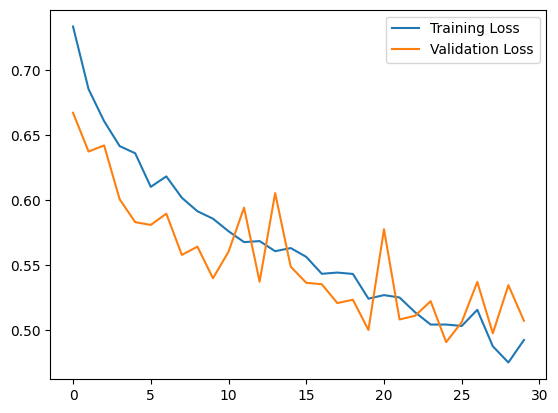

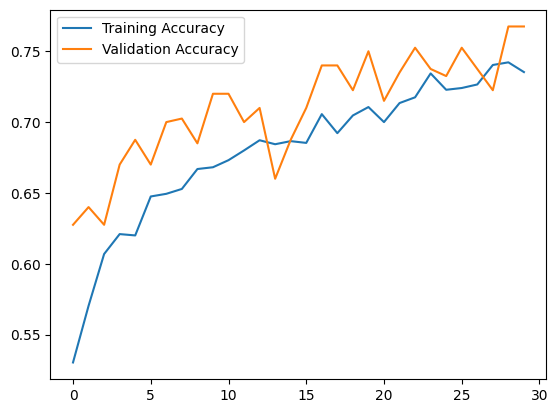

In [34]:
# Plot the losses and accuracies
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()

In [35]:
# Evaluate the model
cvt_13.load_state_dict(torch.load('cvt_13_s_data.pth'))
cvt_13.to(device)

cvt_13.eval()
test_accuracy = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
    outputs = cvt_13(**inputs).logits
    test_accuracy += (outputs.argmax(1) == labels).sum().item()
test_accuracy /= len(test_loader.dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')

C:\Users\waiho\AppData\Local\Temp\ipykernel_7316\2648041204.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cvt_13.load_state_dict(torch.load('cvt_13_s_data.pth'))


Test Accuracy: 0.7350


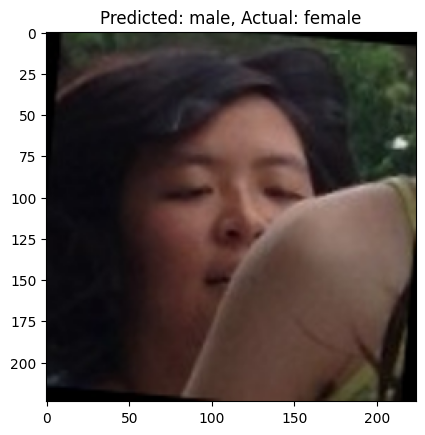

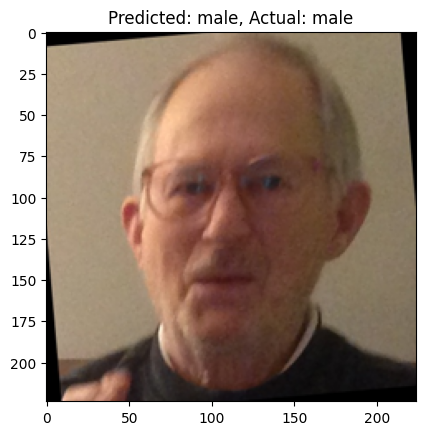

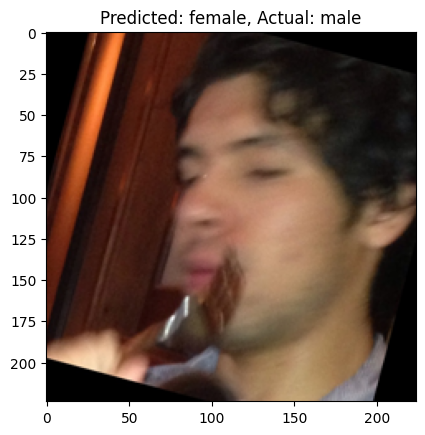

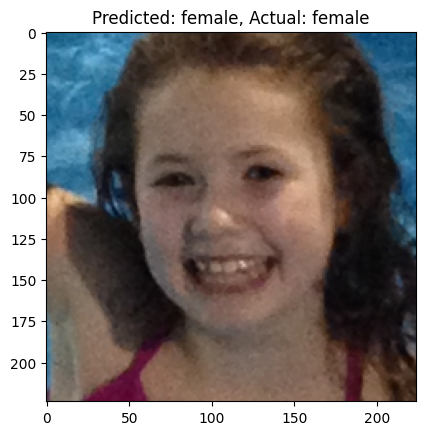

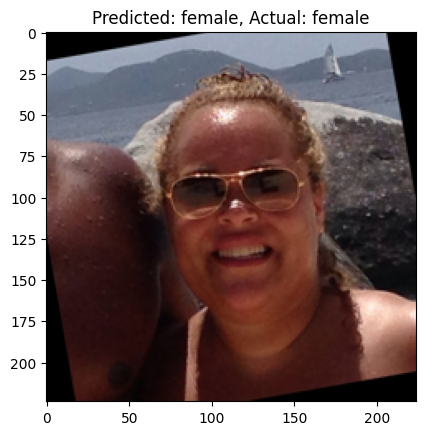

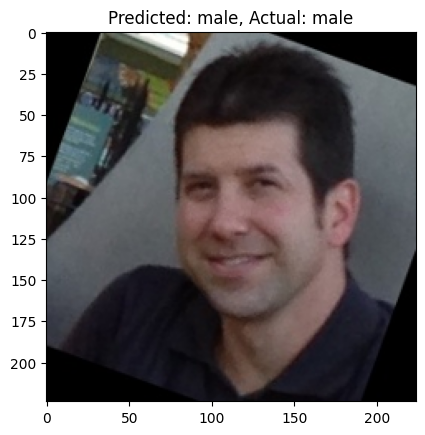

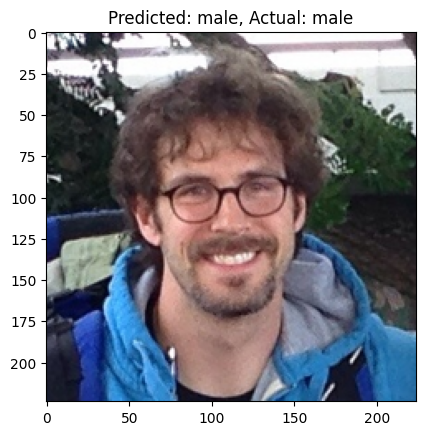

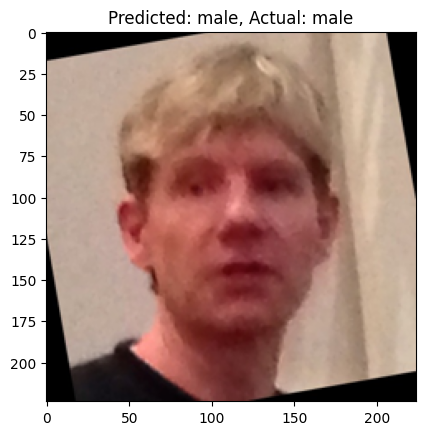

In [36]:
# Show some predictions
cvt_13.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
outputs = cvt_13(**inputs).logits
predicted = outputs.argmax(1)
for i in range(8):
  plt.imshow(images[i].cpu().permute(1, 2, 0))
  predicted_gender = id2label[predicted[i].item()]
  actual_gender = id2label[labels[i].item()]
  plt.title(f'Predicted: {predicted_gender}, Actual: {actual_gender}')
  plt.show()

### Transfer Learning

In [26]:
from transformers import AutoImageProcessor, CvtForImageClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cvt_13 = CvtForImageClassification.from_pretrained("microsoft/cvt-13").to(device)


In [27]:
cvt_13

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [28]:
# Check the number of parameters
total_params = sum([param.numel() for param in cvt_13.parameters()])
print(f'{total_params:,} total parameters.')

19,997,480 total parameters.


In [29]:
from transformers import AutoImageProcessor

# Load the image processor
image_processor = AutoImageProcessor.from_pretrained("microsoft/cvt-13")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [30]:
image_processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [31]:
# Define the loss function and the optimizer
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(cvt_13.parameters(), lr=0.0001)

# Define early stopping
class EarlyStopper:
  def __init__(self, patience=5, min_delta=0.001):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_loss = float('inf')

  def early_stop(self, loss):
    if loss < self.min_loss:
      self.min_loss = loss
      self.counter = 0
    elif loss > (self.min_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

early_stopper = EarlyStopper(patience=5, min_delta=0.001)

In [32]:
# Train the model
n_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
min_val_loss = float('inf')

for epoch in range(n_epochs):
  print(f'===== Epoch {epoch+1} =====')
  train_loss = 0.0
  val_loss = 0.0
  train_accuracy = 0
  val_accuracy = 0

  # Training
  cvt_13.train()
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
    outputs = cvt_13(**inputs).logits
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_accuracy += (outputs.argmax(1) == labels).sum().item()
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_accuracy /= len(train_loader.dataset)
  train_accuracies.append(train_accuracy)

  print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

  # Validation
  cvt_13.eval()
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
      outputs = cvt_13(**inputs).logits
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      val_accuracy += (outputs.argmax(1) == labels).sum().item()
  val_loss /= len(val_loader)
  val_losses.append(val_loss)
  val_accuracy /= len(val_loader.dataset)
  val_accuracies.append(val_accuracy)

  # Save the best model
  if val_loss < min_val_loss:
    torch.save(cvt_13.state_dict(), 'cvt_13_finetune_s_data.pth')
    min_val_loss = val_loss

  # Early stopping
  if early_stopper.early_stop(val_loss):
    print('Early stopping')
    break

  print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

===== Epoch 1 =====
Training Loss: 1.8187, Training Accuracy: 0.5516
Validation Loss: 0.4093, Validation Accuracy: 0.8050
===== Epoch 2 =====
Training Loss: 0.5934, Training Accuracy: 0.7491
Validation Loss: 0.2803, Validation Accuracy: 0.8750
===== Epoch 3 =====
Training Loss: 0.5349, Training Accuracy: 0.7850
Validation Loss: 0.2528, Validation Accuracy: 0.8975
===== Epoch 4 =====
Training Loss: 0.4591, Training Accuracy: 0.8137
Validation Loss: 0.2043, Validation Accuracy: 0.9175
===== Epoch 5 =====
Training Loss: 0.4248, Training Accuracy: 0.8153
Validation Loss: 0.1796, Validation Accuracy: 0.9325
===== Epoch 6 =====
Training Loss: 0.4169, Training Accuracy: 0.8384
Validation Loss: 0.1618, Validation Accuracy: 0.9425
===== Epoch 7 =====
Training Loss: 0.4049, Training Accuracy: 0.8403
Validation Loss: 0.2263, Validation Accuracy: 0.8975
===== Epoch 8 =====
Training Loss: 0.3803, Training Accuracy: 0.8438
Validation Loss: 0.1894, Validation Accuracy: 0.9250
===== Epoch 9 =====
Trai

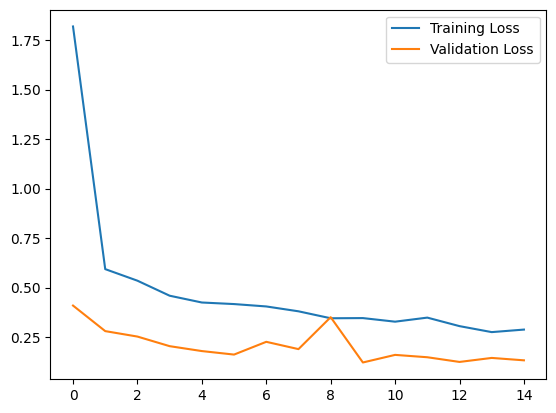

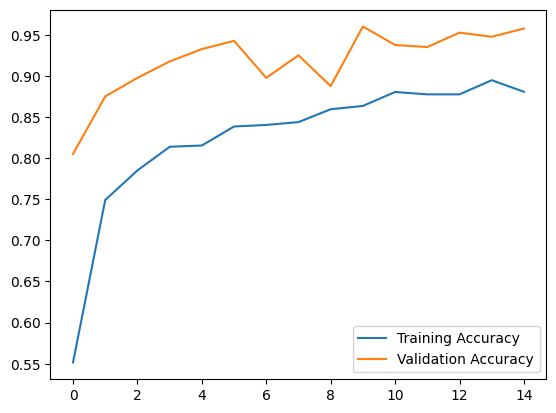

In [33]:
# Plot the losses and accuracies
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()

In [31]:
# Evaluate the model
cvt_13.load_state_dict(torch.load('cvt_13_finetune_s_data.pth'))
cvt_13.to(device)

cvt_13.eval()
test_accuracy = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
    outputs = cvt_13(**inputs).logits
    test_accuracy += (outputs.argmax(1) == labels).sum().item()
test_accuracy /= len(test_loader.dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')

C:\Users\waiho\AppData\Local\Temp\ipykernel_16944\1950407454.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cvt_13.load_state_dict(torch.load('cvt_13_finetune_s_data.pt

Test Accuracy: 0.9500


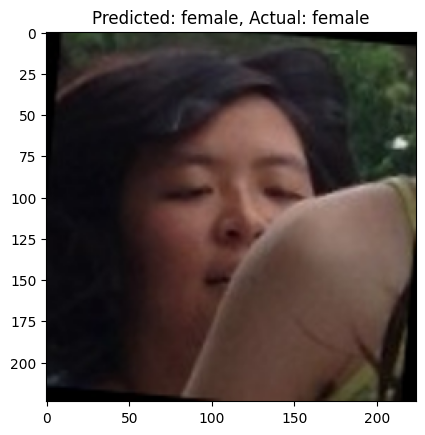

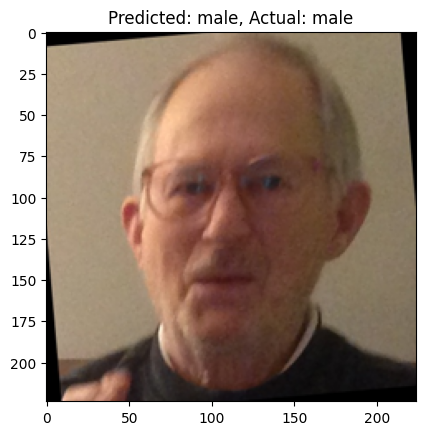

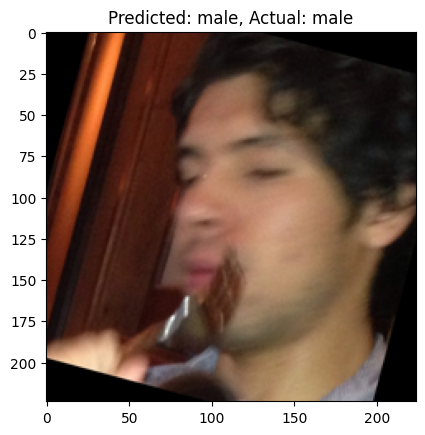

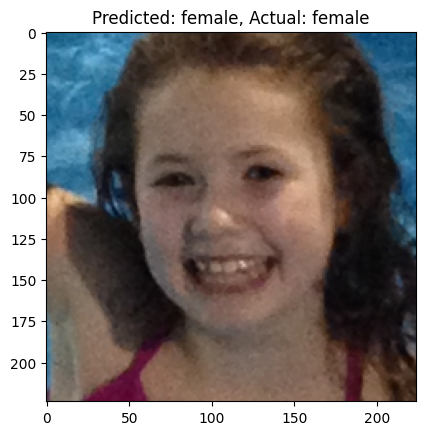

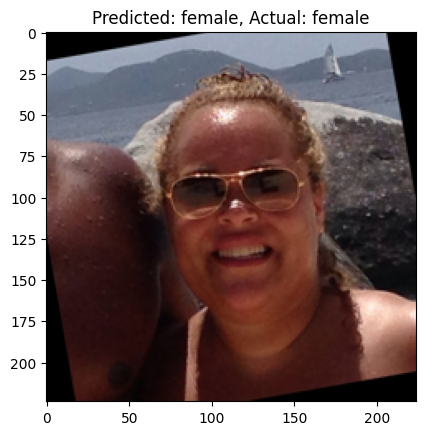

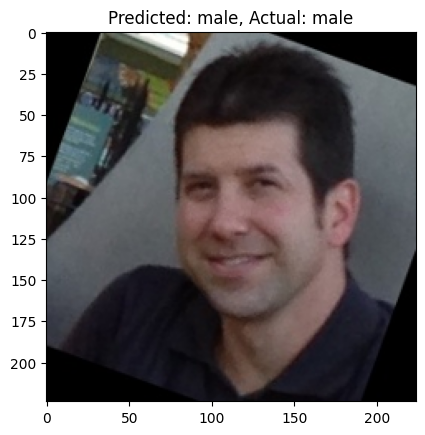

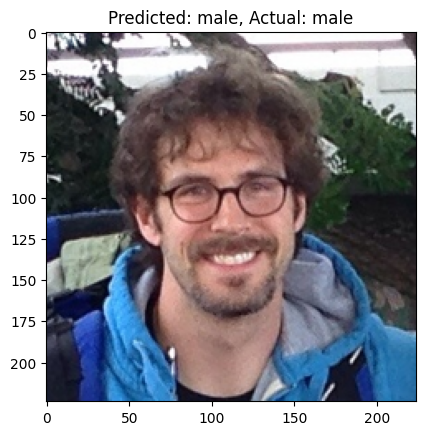

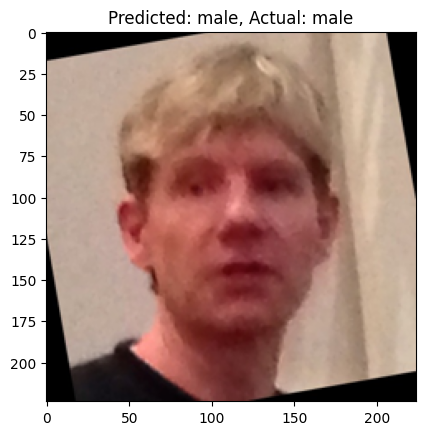

In [32]:
# Show some predictions
cvt_13.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
outputs = cvt_13(**inputs).logits
predicted = outputs.argmax(1)
for i in range(8):
  plt.imshow(images[i].cpu().permute(1, 2, 0))
  predicted_gender = id2label[predicted[i].item()]
  actual_gender = id2label[labels[i].item()]
  plt.title(f'Predicted: {predicted_gender}, Actual: {actual_gender}')
  plt.show()